In [1]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import plotly.graph_objects as go

from PhaseEstimation import general as qmlgen
from PhaseEstimation import vqe

from typing import List, Callable

from matplotlib import rc

In [2]:
import joblib

In [3]:
from tqdm.auto import tqdm

In [4]:
from PhaseEstimation import vqe, qcnn, hamiltonians as hams
from PhaseEstimation import visualization as qplt

import numpy as np
from matplotlib import pyplot as plt
from PhaseEstimation import losses


In [5]:
Ns = [6,12]
side = 100

/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


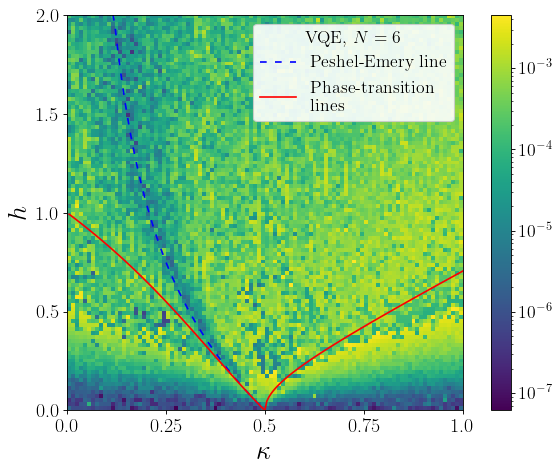

In [22]:
for N in Ns:
    myvqe = vqe.load_vqe(f'../../data/vqes/ANNNI/N{N}n{side}')
    qplt.show_VQE_annni(myvqe, log_heatmap = True, plot3d=False, pe_line=True, phase_lines=True)
    plt.savefig(f'./{N}VQEaccuracy.png',bbox_inches='tight')
    plt.show()

### QCNN probs

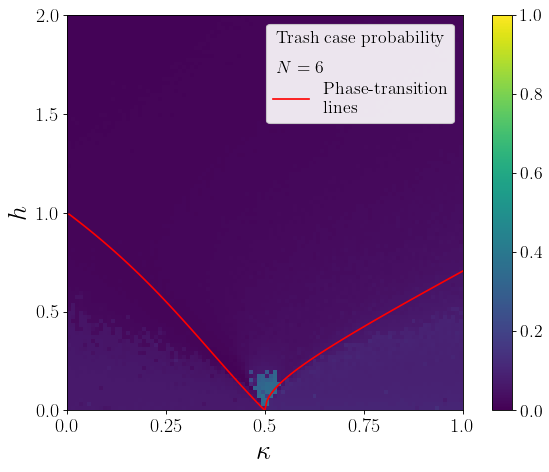

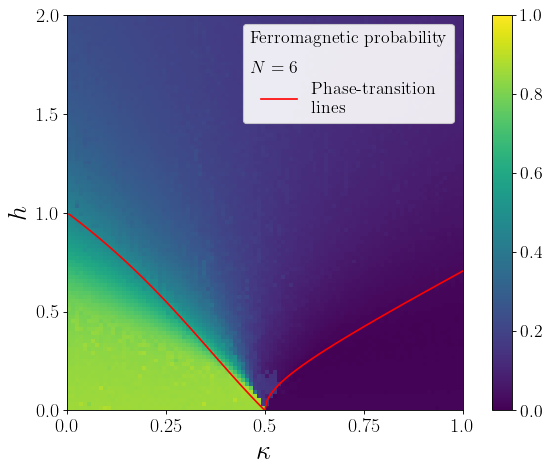

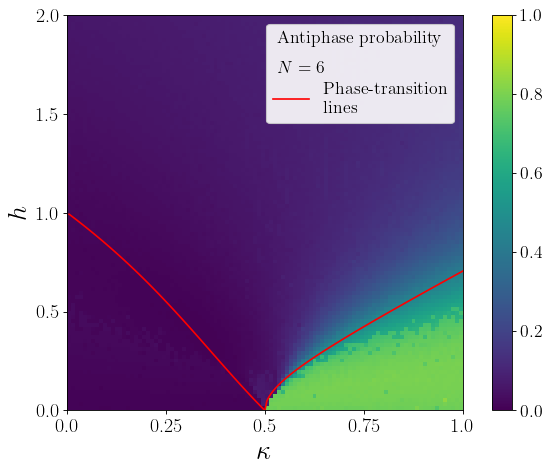

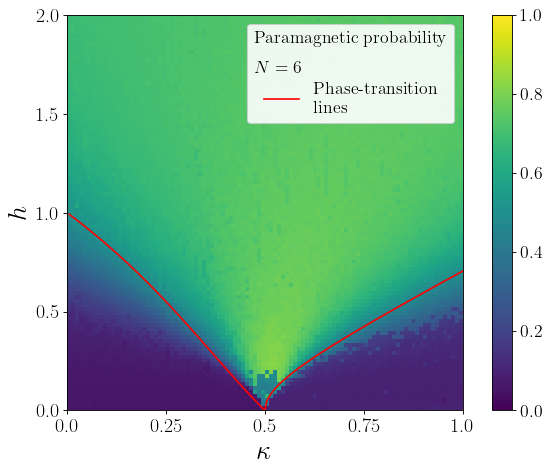

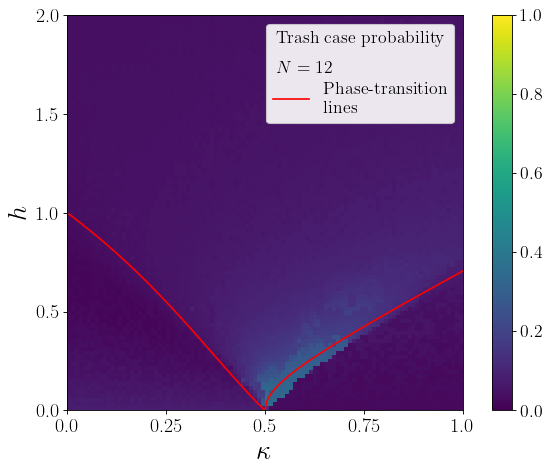

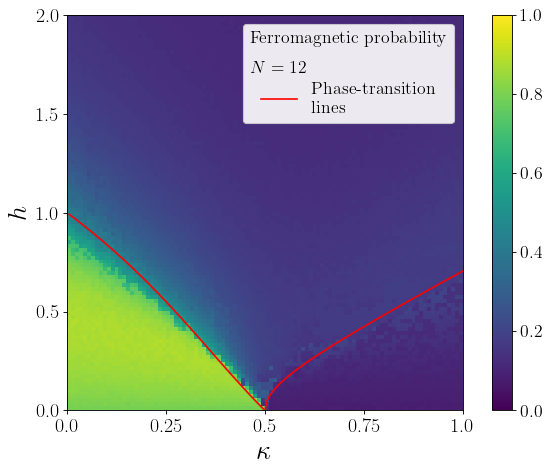

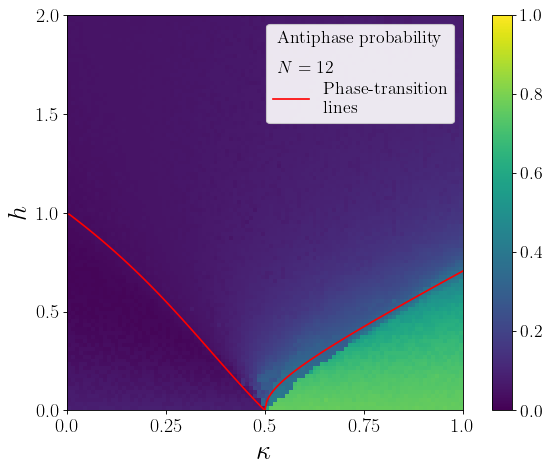

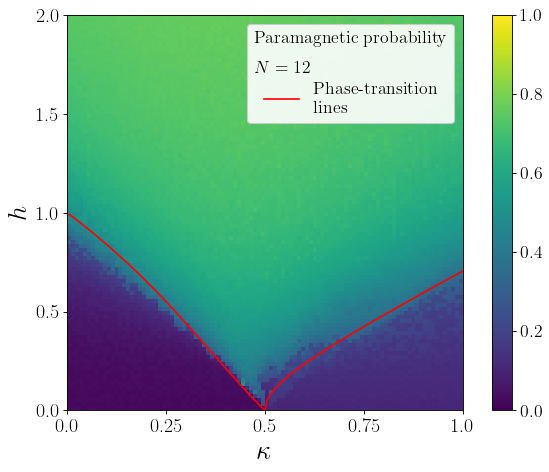

In [ ]:
for N in Ns:
    myvqe = vqe.load_vqe(f'../../data/vqes/ANNNI/N{N}n{100}')
    myqcnn = qcnn.qcnn(myvqe, qcnn.qcnn_circuit, n_outputs = 2)

    myqcnn.params = joblib.load(f'./qcnn_params{N}')
    qplt.show_QCNN_probs(myqcnn, phase_lines = True, fix_clim=True, savefig=f'{N}_phases_probs')

### Mass gap

/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


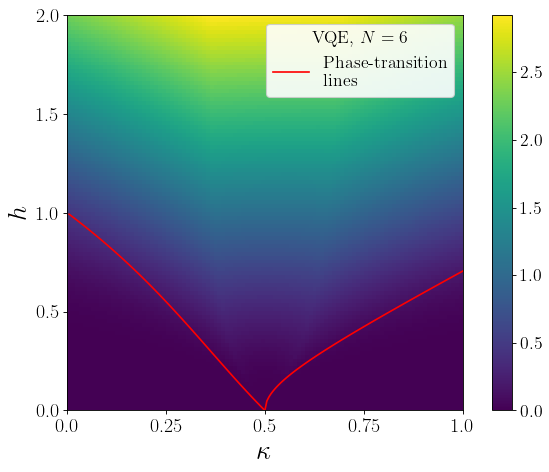

In [14]:
N, side = 6, 100

myvqe = vqe.load_vqe(f'../../data/vqes/ANNNI/N{N}n{side}')

try:
    _, _ = (myvqe.Hs.true_e0, myvqe.Hs.true_e1)
except:
    hams.get_e_psi(myvqe.Hs, 0)
    hams.get_e_psi(myvqe.Hs, 1)

qplt.mass_gap(myvqe, phase_lines = True, pe_line= False)

### Fidelity with true values

In [5]:
N, side = 6, 100

myvqe = vqe.load_vqe(f'../../data/vqes/ANNNI/N{N}n{side}')

/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


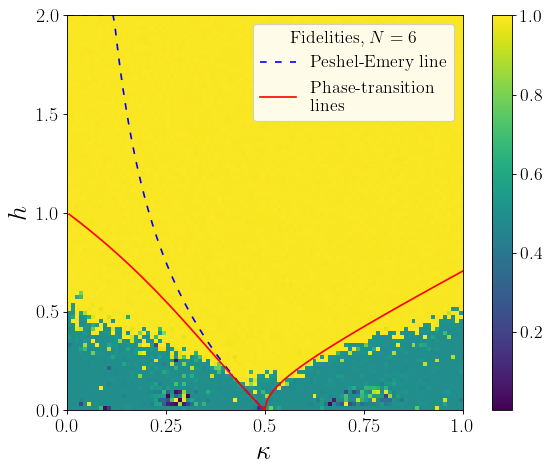

In [6]:
qplt.vqepsi_truepsi_fidelity(myvqe, phase_lines = True, pe_line = True)

### QCNN confidence lines

In [10]:
myvqe = vqe.load_vqe(f'../../data/vqes/ANNNI/N{6}n{100}')
myqcnn = qcnn.qcnn(myvqe, qcnn.qcnn_circuit, n_outputs = 2)
myqcnn.params = joblib.load('./qcnn_params6')

In [152]:
def get_prediction_lines_qcnn(qcnnclass):
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        qcnnclass._vqe_qcnn_circuit(params_vqe, params)

        return qml.probs([int(k) for k in qcnnclass.final_active_wires])

    vcircuit = jax.vmap(
        lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0)
    )

    # 1: Get the main predicted transition lines
    predictions = np.array(vcircuit(qcnnclass.vqe_params))

    transition_line = []
    for column in range(myqcnn.vqe.Hs.n_kappas):
        # Get prediction all across the column 'column' 
        index_column = np.arange(0,myqcnn.vqe.Hs.n_hs) + column * myqcnn.vqe.Hs.n_hs 
        preds_column = np.argmax(predictions[index_column],axis=1)

        index_change = myqcnn.vqe.Hs.n_hs - 1
        for pred in preds_column[::-1]:
            if pred == 1 or  pred == 2:
                break
            index_change -= 1
        
        transition_line.append(index_change)

    predicted_para_line = []
    for column in range(myqcnn.vqe.Hs.n_kappas):
        index_column = np.arange(0,myqcnn.vqe.Hs.n_hs) + column * myqcnn.vqe.Hs.n_hs
        index_change = myqcnn.vqe.Hs.n_hs - 1
        for index in index_column[::-1]:
            if predictions[index][3] > .65:
                index_change -= 1
            else:
                break

        predicted_para_line.append(index_change) 

    predicted_ferro_line = []
    for column in range(myqcnn.vqe.Hs.n_kappas):
        index_column = np.arange(0,myqcnn.vqe.Hs.n_hs) + column * myqcnn.vqe.Hs.n_hs
        index_change = myqcnn.vqe.Hs.n_hs - 1
        for index in index_column[::-1]:
            if predictions[index][1] < .75:
                index_change -= 1
            else:
                break
        
        predicted_ferro_line.append(index_change)

    predicted_anti_line = []
    for column in range(myqcnn.vqe.Hs.n_kappas):
        index_column = np.arange(0,myqcnn.vqe.Hs.n_hs) + column * myqcnn.vqe.Hs.n_hs
        index_change = myqcnn.vqe.Hs.n_hs - 1
        for index in index_column[::-1]:
            if predictions[index][2] < .75:
                index_change -= 1
            else:
                break

        predicted_anti_line.append(index_change)

        
        predicted_ferro_line.append(index_change)


    return np.array(transition_line), np.array(predicted_para_line), np.array(predicted_ferro_line), np.array(predicted_anti_line)


In [153]:
transition_lines, para_line, ferro_line, anti_line = get_prediction_lines_qcnn(myqcnn)

/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/home/saverio/anaconda3/lib/python3.9/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


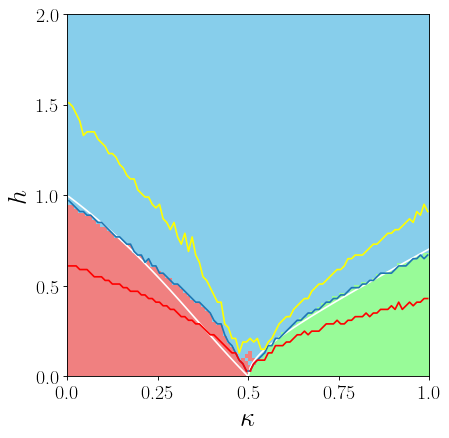

In [157]:
qplt.show_QCNN_classificationANNNI(
    myqcnn,
    hard_thr=True,
    train_index=[],
    label=False,
    info=False,
    morelines=False)

plt.plot(myqcnn.vqe.Hs.n_hs - transition_lines - 2)
plt.plot(myqcnn.vqe.Hs.n_hs - para_line        - 2, color='yellow')
plt.plot(myqcnn.vqe.Hs.n_hs - ferro_line[:50]  - 2, color='red')
plt.plot(np.arange(50,100), myqcnn.vqe.Hs.n_hs - anti_line[50:]   - 2, color='red')

In [81]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import plotly.graph_objects as go
from tqdm.auto import tqdm

from PhaseEstimation import general as qmlgen
from PhaseEstimation import vqe

from typing import List, Callable

from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
rc("font", **{"family": "serif", "serif": ["Computer Modern Roman"]})
rc("text", usetex=True)

def getlines(
    func: Callable, xrange: List[float], side: int, color: str, res: int = 100
):
    """
    Plot function func from xrange[0] to xrange[1]
    This first function assumes your parameter ranges are
    > h     : [ 0, 2]
    > kappa : [ 0,-1]

    """
    xs = np.linspace(xrange[0], xrange[1], res)
    ys = func(xs)
    plt.plot(side * xs - 0.5, side - ys * side / 2 - 0.5, color=color, alpha=0.8)

def getlines_from_vqe(
    vqeclass, func: Callable, xrange: List[float], res: int = 100, **kwargs
):
    """
    Plot function func from xrange[0] to xrange[1]
    This function uses the VQE class to plot the function 
    according to the vqe ranges of its parameters
    """

    # Get information from vqeclass for plotting
    # (func needs to be resized)
    side_x = vqeclass.Hs.n_kappas
    side_y = vqeclass.Hs.n_hs
    max_x  = vqeclass.Hs.kappa_max

    yrange = [0, vqeclass.Hs.h_max]
    
    xs = np.linspace(xrange[0], xrange[1], res)
    ys = func(xs)

    ys[ys > yrange[1]] = yrange[1]
    
    corrected_xs = (side_x * xs / max_x - 0.5)

    plt.plot(corrected_xs, side_y - ys * side_y / yrange[1] - 0.5, **kwargs)

In [10]:
def show_QCNN_classificationANNNI(
    qcnnclass,
    hard_thr=True,
    train_index=[],
    label=False,
    info=False,
    morelines=False,
):

    plt.figure(figsize=(8, 6), dpi=80)

    circuit = qcnnclass._vqe_qcnn_circuit
    sidex = qcnnclass.vqe.Hs.n_kappas
    sidey = qcnnclass.vqe.Hs.n_hs

    if hard_thr:

        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)

            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]

        vcircuit = jax.vmap(
            lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0)
        )

        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis=2))
        c = []
        for pred in predictions:
            if (pred == [0, 1]).all():
                c.append(0)
            elif (pred == [1, 1]).all():
                c.append(1)
            elif (pred == [1, 0]).all():
                c.append(2)
            else:
                c.append(3)

        phases = mpl.colors.ListedColormap(
            ["lightcoral", "skyblue", "black", "palegreen"]
        )
        norm = mpl.colors.BoundaryNorm(np.arange(0, 4), phases.N)
        plt.imshow(np.rot90(np.reshape(c, (sidex, sidey))), cmap=phases, norm=norm)
    else:

        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)

            return qml.probs([int(k) for k in qcnnclass.final_active_wires])

        vcircuit = jax.vmap(
            lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0)
        )

        predictions = np.array(vcircuit(qcnnclass.vqe_params))
        mygreen = np.array([90, 255, 100]) / 255
        myblue = np.array([50, 50, 200]) / 255
        myyellow = np.array([300, 270, 0]) / 255
        c = []

        rgb_probs = np.ndarray(shape=(sidex * sidey, 3), dtype=float)

        for i, pred in enumerate(predictions):
            rgb_probs[i] = pred[3] * mygreen + pred[1] * myblue + pred[2] * myyellow

        rgb_probs = np.rot90(np.reshape(rgb_probs, (sidex, sidey, 3)))

        plt.imshow(rgb_probs, alpha=1)

    plt.ylabel(r"$h$", fontsize=24)
    plt.xlabel(r"$\kappa$", fontsize=24)
    plt.tick_params(axis="x", labelsize=18)
    plt.tick_params(axis="y", labelsize=18)

    ticks_x = [-.5 , qcnnclass.vqe.Hs.n_kappas/4 - .5, qcnnclass.vqe.Hs.n_kappas/2 - .5 , 3*qcnnclass.vqe.Hs.n_kappas/4 - .5, qcnnclass.vqe.Hs.n_kappas - .5]
    ticks_y = [-.5 , qcnnclass.vqe.Hs.n_hs/4 - .5, qcnnclass.vqe.Hs.n_hs/2 - .5 , 3*qcnnclass.vqe.Hs.n_hs/4 - .5, qcnnclass.vqe.Hs.n_hs - .5]

    plt.xticks(
        ticks= ticks_x,
        labels=[np.round(k * qcnnclass.vqe.Hs.kappa_max  / 4, 2) for k in range(0, 5)],
    )
    plt.yticks(
        ticks=ticks_y,
        labels=[np.round(k * qcnnclass.vqe.Hs.h_max / 4, 2) for k in range(4, -1, -1)],
    )

    if len(train_index) > 0:
        raise Exception('Out of support')
        x_star, y_star = [], []
        for idx in train_index:
            x_star.append(idx // side - 1)
            y_star.append(side - idx % side)
            if x_star[-1] == -1:
                x_star[-1] = x_star[-1] + 1.5
            if y_star[-1] == side:
                y_star[-1] = y_star[-1] - 1.5

        plt.scatter(
            x_star,
            y_star,
            marker="o",
            color="red",
            s=30,
            alpha=1,
            label=r"Training Points $\mathcal{{S}}_U^{14}$",
        )
        plt.ylim(sidey - 1, 0)
        plt.xlim(0, sidex - 1)

    getlines_from_vqe(qcnnclass.vqe, qmlgen.paraanti, [0.5, 1], res=100, color = "white")
    getlines_from_vqe(qcnnclass.vqe, qmlgen.paraferro, [0, 0.5], res=100, color = 'white')
    if morelines:
        getlines_from_vqe(qcnnclass.vqe, qmlgen.peshel_emery, [0, 0.5], res=100, color = 'cyan')
        getlines_from_vqe(qcnnclass.vqe, qmlgen.b1, [0.5, 1], res=100, color = "blue")

    if label:
        plt.figtext(0.28, 0.79, "(" + label + ")", color="black", fontsize=20)

    if info:
        plt.text(
            sidex * 0.5,
            sidey * 0.4,
            "para.",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
        )
        plt.text(
            sidex * 0.18,
            sidey * 0.88,
            "ferro.",
            color="white",
            fontsize=20,
            ha="center",
            va="center",
        )
        plt.text(
            sidex * 0.82,
            sidey * 0.88,
            "anti.",
            color="black",
            fontsize=20,
            ha="center",
            va="center",
        )

        leg = plt.legend(
            bbox_to_anchor=(1, 1),
            loc="upper right",
            fontsize=16,
            facecolor="white",
            markerscale=1,
            framealpha=0.9,
            title=r"QCNN,     $N = {0}$".format(str(qcnnclass.N)),
            title_fontsize=16,
        )
        leg.get_frame().set_boxstyle("Square")

        # change the line width for the legend
        for line in leg.get_lines():
            line.set_linewidth(4.0)